### Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os
import joblib
from skimage.io import imread
from skimage.transform import resize, rescale
from collections import Counter
from sklearn.model_selection import train_test_split
from skimage.feature import hog
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler, Normalizer
import skimage
import cv2
import random
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from sklearn.utils import class_weight

# Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
# from xgboost import XGBClassifier
# from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression

import albumentations as A
from PIL import Image as im
# from autoalbument.faster_autoaugment.models import ClassificationModel
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Read and Analyies Data

In [2]:
train = pd.read_csv('train_set.csv')
test = pd.read_csv('test_set.csv')
sub_sample = pd.read_csv('sample_submission.csv')

In [3]:
train.head()

,Image,Category
0,275,LYMPHOCYTE
1,94,EOSINOPHIL
2,109,EOSINOPHIL
3,18,NEUTROPHIL
4,79,NEUTROPHIL


In [4]:
train.shape

(279, 2)

In [5]:
test.head()

,Image
0,200
1,402
2,370
3,281
4,198


In [6]:
test.shape

(70, 1)

In [7]:
def ReadAndResize_data(path, pklname, width=150, height=None):
    height = height if height is not None else width
    train_list = []
    test_list = []
    train_data = dict()
    train_data['description'] = 'resized ({0}x{1})Blood_Disease images in rgb'.format(int(width), int(height))
    train_data['label'] = []
    train_data['filename'] = []
    train_data['data'] = []
    train_pklname = f"Train_{pklname}_{width}x{height}px.pkl"
    test_data = dict()
    test_data['description'] = 'resized ({0}x{1})Blood_Disease images in rgb'.format(int(width), int(height))
    test_data['filename'] = []
    test_data['data'] = []
    test_pklname = f"Test_{pklname}_{width}x{height}px.pkl"
    for file in os.listdir(path):
        if file[-3:] in {'jpg', 'png'}:
            if int(file[11:16]) in train.iloc[:, 0].tolist():
                im = imread(os.path.join(path, file))
                im = resize(im, (width, height))
                train_data['label'].append(str(train[train['Image']==int(file[11:16])]['Category'].tolist()[0]))
                train_data['filename'].append(file)
                train_data['data'].append(im)
                train_list.append(int(file[11:16]))
            elif int(file[11:16]) in test.iloc[:, 0].tolist():
                im = cv2.imread(os.path.join(path, file))
                im = resize(im, (width, height))
                test_data['filename'].append(file)
                test_data['data'].append(im)
                test_list.append(int(file[11:16]))
                
    joblib.dump(train_data, train_pklname)
    joblib.dump(test_data, test_pklname)
    return train_list, test_list

In [8]:
path = 'Images/Images'
width = 400
height = 400
pklname = 'BloodImage'
train_lst, test_lst = ReadAndResize_data(path=path, pklname=pklname, width=width, height=height)

In [9]:
train_data = joblib.load(f'Train_{pklname}_{width}x{height}px.pkl')
test_data = data = joblib.load(f'Test_{pklname}_{width}x{height}px.pkl')

In [10]:
print('number of samples: ', len(train_data['data']))
print('keys: ', list(train_data.keys()))
print('description: ', train_data['description'])
print('image shape: ', train_data['data'][0].shape)
print('labels:', np.unique(train_data['label']))
Counter(train_data['label'])

number of samples:  278
keys:  ['description', 'label', 'filename', 'data']
description:  resized (400x400)Blood_Disease images in rgb
image shape:  (400, 400, 3)
labels: ['EOSINOPHIL' 'LYMPHOCYTE' 'MONOCYTE' 'NEUTROPHIL']


Counter({'NEUTROPHIL': 166,
         'EOSINOPHIL': 74,
         'MONOCYTE': 16,
         'LYMPHOCYTE': 22})

In [11]:
np.array(train_data['data']).shape

(278, 400, 400, 3)

In [12]:
print('number of samples: ', len(test_data['data']))
print('keys: ', list(test_data.keys()))
print('description: ', test_data['description'])
print('image shape: ', test_data['data'][0].shape)

number of samples:  69
keys:  ['description', 'filename', 'data']
description:  resized (400x400)Blood_Disease images in rgb
image shape:  (400, 400, 3)


In [13]:
set(train['Image'].tolist())-set(train_lst)

{116}

In [14]:
set(test['Image'].tolist())-set(test_lst)

{280}

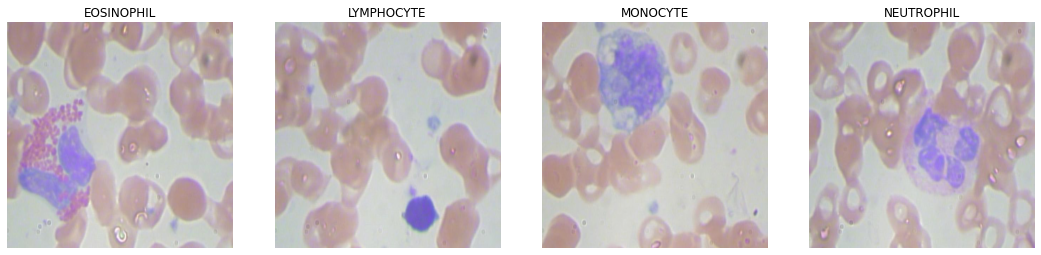

In [15]:
labels = np.unique(train_data['label'])
fig, axes = plt.subplots(1, len(labels))
fig.set_size_inches(15,4)
fig.tight_layout()
for ax, label in zip(axes, labels):
    idx = train_data['label'].index(label)
    ax.imshow(train_data['data'][idx])
    ax.axis('off')
    ax.set_title(label)

In [16]:
def classi_repo(valid_target, pred, model_name):
    print(model_name+':')
    print('F1-Score: ', f1_score(valid_target, pred , average="micro"))
#     print('ROC_AUC_score: ', roc_auc_score(valid_target, pred), '\n\n')
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))
    clf_report = classification_report(valid_target,
                                   pred,
                                   output_dict=True)
    g = sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True, cmap='Blues', ax=ax1)
    g.set_title('Classification Report\n\n');

    cf_matrix = confusion_matrix(valid_target, pred)
    g1 = sns.heatmap(cf_matrix, annot=True, cmap='Blues',ax=ax2)
    g1.set_title('Confusion Matrix\n\n');
    g1.set_xlabel('\nPredicted Values')
    g1.set_ylabel('Actual Values ');
    g1.xaxis.set_ticklabels(['EOSINO','LYMPHO','MONO','NEUTRO'], rotation=90, ha='right', fontsize=10)
    g1.yaxis.set_ticklabels(['EOSINO','LYMPHO','MONO','NEUTRO'], rotation=0, ha='right', fontsize=10)    
    plt.show()

### Resampling Function

In [17]:
# Transformer = {}
# Transformer['transform1'] = A.Compose([A.HorizontalFlip(always_apply=True, p=0.5),])
# Transformer['transform2'] = A.Compose([A.GaussianBlur(always_apply=True,p=0.5),])
# Transformer['transform3'] = A.Compose([A.GaussNoise(always_apply=True,p=0.5),])
# Transformer['transform4'] = A.Compose([A.Sharpen(always_apply=True,p=0.5),])
# Transformer['transform5'] = A.Compose([A.CLAHE(always_apply=True,p=0.5),])
# Transformer['transform6'] = A.Compose([A.RGBShift(always_apply=True,p=0.5),])

In [18]:
def visualize(image):
    plt.figure(figsize=(5, 5))
    plt.axis('off')
    plt.imshow(image)

In [19]:
# NEUTROPHIL    124
# EOSINOPHIL     55
# LYMPHOCYTE     17
# MONOCYTE       12
def Augmentation(path, trans, aug):
    count1 = 208
    count2 = 0
    for key, val in aug.items():
        filename = new_df[new_df['label']==str(key)]['filename'].values.tolist()
        for pic in range(int(val)):
            item = random.choice(filename)
            my_pic = im.open("Images/Images/"+str(item))
            my_pic = np.array(my_pic)
            transform = trans(image=my_pic)["image"]
            img_transform =im.fromarray(transform)
            img_transform.save(path+str(key)+"/BloodImage_00"+str(500+count2)+".jpg")
            new_df.loc[count1] = ['BloodImage_00'+str(500+count2)+'.jpg', str(key)]
            count1+=1
            count2+=1
# def dataAug_Mono(lst, path):
#     count1 = 0
#     count2 = 278
#     for pic in lst:
#         pic = im.open("/home/huzaifa/Downloads/T_UAE training/ML2/Blood_Disease_classification/Data/Images/Images/"+str(pic))
#         pic = np.array(pic)
#         # norm_image = cv2.normalize(pic, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
#         for trans in Transformer.values():
#             transform = trans(image=pic)["image"]
#             img_transform =im.fromarray(transform)
#             # if img_transform.mode != 'RGB':
#             #     img_transform = img_transform.convert('RGB')
#             img_transform.save(path+"MONOCYTE/BloodImage_00"+str(500+count1)+".jpg")
#             new_df.loc[count2] = ['BloodImage_00'+str(500+count1)+'.jpg', 'MONOCYTE']
#             count2+=1
#             count1 += 1
#     return count2

# def dataAug_Lympho(lst, path, trans, start):
#     count1 = 0
#     count3 = start
#     for pic in lst:
#         pic = im.open("/home/huzaifa/Downloads/T_UAE training/ML2/Blood_Disease_classification/Data/Images/Images/"+str(pic))
#         pic = np.array(pic)
#         count2 = 1
#         for trans in Transformer.values():
#             if count2 == 6:
#                 break
#             else:
#                 transform = trans(image=pic)["image"] 
#                 img_transform =im.fromarray(transform)
#                 img_transform.save(path+"LYMPHOCYTE/BloodImage_00"+str(600+count1)+".jpg")
#                 new_df.loc[count3] = ['BloodImage_00'+str(600+count1)+'.jpg', 'LYMPHOCYTE']
#                 count3+=1
#                 count1 += 1
#             count2+=1
#     return count3
            
# def dataAug_Eosin(lst, path, trans, start):
#     count = 0
#     flag = start
#     for pic in lst:
#         pic = im.open("/home/huzaifa/Downloads/T_UAE training/ML2/Blood_Disease_classification/Data/Images/Images/"+str(pic))
#         pic = np.array(pic)
#         # norm_image = cv2.normalize(pic, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
#         trans = A.Compose([
#         A.RandomRotate90(),
#         A.Flip(),
#         A.Transpose(),
#         A.OneOf([
#             A.IAAAdditiveGaussianNoise(),
#             A.GaussNoise(),
#         ], p=0.2),
#         A.OneOf([
#             A.MotionBlur(p=.2),
#             A.MedianBlur(blur_limit=3, p=0.1),
#             A.Blur(blur_limit=3, p=0.1),
#         ], p=0.2),
#         A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.2),
#         A.OneOf([
#             A.OpticalDistortion(p=0.3),
#             A.GridDistortion(p=.1),
#             A.IAAPiecewiseAffine(p=0.3),
#         ], p=0.2),
#         A.OneOf([
#             A.CLAHE(clip_limit=2),
#             A.IAASharpen(),
#             A.IAAEmboss(),
#             A.RandomBrightnessContrast(),            
#         ], p=0.3),
#         A.HueSaturationValue(p=0.3),
#     ])
#         transform = trans(image=pic)["image"] 
#         img_transform =im.fromarray(transform)
#         # if img_transform.mode != 'RGB':
#         #         img_transform = img_transform.convert('RGB')
#         img_transform.save(path+"EOSINOPHIL/BloodImage_00"+str(700+count)+".jpg")
#         new_df.loc[flag] = ['BloodImage_00'+str(700+count)+'.jpg', 'EOSINOPHIL']
#         flag+=1
#         count+=1

### Split Data

In [20]:
# Data = np.array(train_data['data'], dtype='float32')
Data = np.array(train_data['filename'])
Target = np.array(train_data['label'])
Test_data=np.array(test_data['data'])

In [21]:
X_train, X_val, y_train, y_val = train_test_split(
    Data, 
    Target, 
    test_size=0.25,
    shuffle=True,
    stratify=Target,
    random_state=42,
)

In [22]:
print('The shape of X_train', X_train.shape)
print('The shape of y_train', y_train.shape)
print('The shape of X_val', X_val.shape)
print('The shape of y_val', y_val.shape)

The shape of X_train (208,)
The shape of y_train (208,)
The shape of X_val (70,)
The shape of y_val (70,)


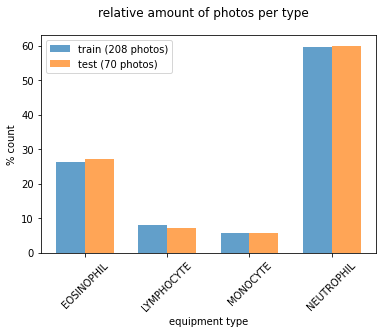

In [23]:
def plot_bar(y, loc='left', relative=True):
    width = 0.35
    if loc == 'left':
        n = -0.5
    elif loc == 'right':
        n = 0.5
    
    unique, counts = np.unique(y, return_counts=True)
    sorted_index = np.argsort(unique)
    unique = unique[sorted_index]
     
    if relative:
        counts = 100*counts[sorted_index]/len(y)
        ylabel_text = '% count'
    else:
        counts = counts[sorted_index]
        ylabel_text = 'count'
         
    xtemp = np.arange(len(unique))
     
    plt.bar(xtemp + n*width, counts, align='center', alpha=.7, width=width)
    plt.xticks(xtemp, unique, rotation=45)
    plt.xlabel('equipment type')
    plt.ylabel(ylabel_text)
 
plt.suptitle('relative amount of photos per type')
plot_bar(y_train, loc='left')
plot_bar(y_val, loc='right')
plt.legend([
    'train ({0} photos)'.format(len(y_train)), 
    'test ({0} photos)'.format(len(y_val))
]);

In [24]:
pd.Series(y_train).value_counts()

NEUTROPHIL    124
EOSINOPHIL     55
LYMPHOCYTE     17
MONOCYTE       12
dtype: int64

### Resampling Process

#### Train Sets

In [25]:
# new_df = pd.concat([pd.DataFrame(X_train.reshape(X_train.shape[0],-1)),pd.Series(y_train,name='Category')],axis=1)
new_df = pd.concat([pd.Series(X_train, name='filename'), pd.Series(y_train, name='label')], axis=1)
new_df.tail()

,filename,label
203,BloodImage_00020.jpg,LYMPHOCYTE
204,BloodImage_00407.jpg,NEUTROPHIL
205,BloodImage_00386.jpg,NEUTROPHIL
206,BloodImage_00382.jpg,NEUTROPHIL
207,BloodImage_00327.jpg,NEUTROPHIL


In [26]:
print('The shape of train data: ', new_df.shape)

The shape of train data:  (208, 2)


In [27]:
# Mono = new_df[new_df['label']=='MONOCYTE']
# Lympho = new_df[new_df['label']=='LYMPHOCYTE']
# Eosin = new_df[new_df['label']=='EOSINOPHIL']

In [28]:
path = 'Images/'
aug = {'MONOCYTE':108, 'LYMPHOCYTE':108, 'EOSINOPHIL':80, 'NEUTROPHIL':26}
trans = A.Compose([
        A.RandomRotate90(),
        A.Flip(),
        A.Transpose(),
        A.OneOf([
            A.IAAAdditiveGaussianNoise(),
            A.GaussNoise(),
        ], p=0.2),
        A.OneOf([
            A.MotionBlur(p=.2),
            A.MedianBlur(blur_limit=3, p=0.1),
            A.Blur(blur_limit=3, p=0.1),
        ], p=0.2),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.2),
        A.OneOf([
            A.OpticalDistortion(p=0.3),
            A.GridDistortion(p=.1),
            A.IAAPiecewiseAffine(p=0.3),
        ], p=0.2),
        A.OneOf([
            A.CLAHE(clip_limit=2),
            A.IAASharpen(),
            A.IAAEmboss(),
            A.RandomBrightnessContrast(),            
        ], p=0.3),
        A.HueSaturationValue(p=0.3),
    ])
random.seed(111)
Augmentation(path, trans, aug)
# ind2 = dataAug_Lympho(Lympho, path, trans, ind1)
# dataAug_Eosin(Eosin, path, trans, ind2)

In [29]:
filename = new_df["filename"].values.tolist()

In [63]:
new_df.shape

(530, 2)

In [30]:
def ReadAndResize_data2(path, pklname, include, width=150, height=None):
    height = height if height is not None else width
    train_list = []
    test_list = []
    X_y_train = dict()
    X_y_train['description'] = 'resized ({0}x{1})Blood_Disease images in rgb'.format(int(width), int(height))
    X_y_train['label'] = []
    X_y_train['filename'] = []
    X_y_train['data'] = []
    train_pklname = f"X_y_Train_{pklname}_{width}x{height}px.pkl"
    for subdir in os.listdir(path):
        if subdir in include:
            print(subdir)
            current_path = os.path.join(path, subdir)
            # if subdir == 'Images':
            for file in os.listdir(current_path):
                if file[-3:] in {'jpg', 'png'}:
                    if subdir == 'Images':
                        if file in filename and int(file[11:16]) in train.iloc[:, 0].tolist():
                            im = imread(os.path.join(current_path, file))
                            im = resize(im, (width, height))
                            X_y_train['label'].append(str(train[train['Image']==int(file[11:16])]['Category'].tolist()[0]))
                            X_y_train['filename'].append(file)
                            X_y_train['data'].append(im)
                            train_list.append(int(file[11:16]))
                    else:
                        if file in filename:
                            im = imread(os.path.join(current_path, file))
                            im = resize(im, (width, height))
                            X_y_train['label'].append(str(subdir))
                            X_y_train['filename'].append(file)
                            X_y_train['data'].append(im)
                            train_list.append(int(file[11:16]))
            
    joblib.dump(X_y_train, train_pklname)
    return train_list
path = 'Images/'
#path = fr'{os.getenv("HOME")}/Downloads/T_UAE training/ML2/Blood_Disease_classification/Data/Images'
include = ['Images', 'MONOCYTE', 'LYMPHOCYTE', 'EOSINOPHIL', 'NEUTROPHIL']
width = 400
height = 400
pklname = 'BloodImage'
train_ls = ReadAndResize_data2(path=path, pklname=pklname, include=include, width=width, height=height)
X_y_train = joblib.load(f'X_y_Train_{pklname}_{width}x{height}px.pkl')

EOSINOPHIL
Images
LYMPHOCYTE
MONOCYTE
NEUTROPHIL


In [31]:
print('number of samples: ', len(X_y_train['data']))
print('keys: ', list(X_y_train.keys()))
print('description: ', X_y_train['description'])
print('image shape: ', X_y_train['data'][0].shape)
print('labels:', np.unique(X_y_train['label']))
Counter(X_y_train['label'])

number of samples:  530
keys:  ['description', 'label', 'filename', 'data']
description:  resized (400x400)Blood_Disease images in rgb
image shape:  (400, 400, 3)
labels: ['EOSINOPHIL' 'LYMPHOCYTE' 'MONOCYTE' 'NEUTROPHIL']


Counter({'EOSINOPHIL': 135,
         'NEUTROPHIL': 150,
         'LYMPHOCYTE': 125,
         'MONOCYTE': 120})

In [32]:
X_y_train = joblib.load(f'X_y_Train_{pklname}_{width}x{height}px.pkl')

In [33]:
X_train = np.asarray(X_y_train['data'])
y_train = np.array(X_y_train['label'])

In [34]:
X_train.shape

(530, 400, 400, 3)

#### Validation Sets

In [35]:
val_df = pd.concat([pd.Series(X_val, name='filename'), pd.Series(y_val, name='label')], axis=1)
val_df.head()

,filename,label
0,BloodImage_00300.jpg,NEUTROPHIL
1,BloodImage_00354.jpg,NEUTROPHIL
2,BloodImage_00345.jpg,EOSINOPHIL
3,BloodImage_00334.jpg,NEUTROPHIL
4,BloodImage_00160.jpg,EOSINOPHIL


In [36]:
val_filename = val_df["filename"].values.tolist()
val_df.shape

(70, 2)

In [37]:
def ReadAndResize_data(path, pklname, width=150, height=None):
    height = height if height is not None else width
    train_list = []
    test_list = []
    val_data = dict()
    val_data['description'] = 'resized ({0}x{1})Blood_Disease images in rgb'.format(int(width), int(height))
    val_data['label'] = []
    val_data['filename'] = []
    val_data['data'] = []
    train_pklname = f"Val_{pklname}_{width}x{height}px.pkl"
    for file in os.listdir(path):
        if file[-3:] in {'jpg', 'png'}:
            if file in val_filename and int(file[11:16]) in train.iloc[:, 0].tolist():
                im = imread(os.path.join(path, file))
                im = resize(im, (width, height))
                val_data['label'].append(str(train[train['Image']==int(file[11:16])]['Category'].tolist()[0]))
                val_data['filename'].append(file)
                val_data['data'].append(im)
                train_list.append(int(file[11:16]))
                
    joblib.dump(val_data, train_pklname)
    return train_list
path = 'Images/Images'
width = 400
height = 400
pklname = 'BloodImage'
val_lst = ReadAndResize_data(path=path, pklname=pklname, width=width, height=height)
val_data = joblib.load(f'Val_{pklname}_{width}x{height}px.pkl')

In [39]:
print('number of samples: ', len(val_data['data']))
print('keys: ', list(val_data.keys()))
print('description: ', val_data['description'])
print('image shape: ', val_data['data'][0].shape)
print('labels:', np.unique(val_data['label']))
Counter(val_data['label'])

number of samples:  70
keys:  ['description', 'label', 'filename', 'data']
description:  resized (400x400)Blood_Disease images in rgb
image shape:  (400, 400, 3)
labels: ['EOSINOPHIL' 'LYMPHOCYTE' 'MONOCYTE' 'NEUTROPHIL']


Counter({'NEUTROPHIL': 42, 'MONOCYTE': 4, 'EOSINOPHIL': 19, 'LYMPHOCYTE': 5})

In [69]:
X_val = np.asarray(val_data['data'])
y_val = np.array(val_data['label'])

In [70]:
X_val.shape

(70, 400, 400, 3)

In [42]:
# transform = A.Compose([
#     A.HorizontalFlip(p=0.5),
#     A.GaussianBlur(p=0.9),
#     A.RandomBrightness(brightness_limit=1, contrast_limit=1, p=1.0),
# ])

In [43]:
# another_pillow_image = imread(os.path.join('/home/huzaifa/Downloads/T_UAE training/ML2/Blood_Disease_classification/Data/Images/Images/', 'BloodImage_00055.jpg'))
# another_image = np.array(another_pillow_image)
# another_transformed_image = Transformer['transform1'](image=another_image)["image"]
# another_transformed_image = transform(image=another_image)["image"]

In [44]:
# def visualize_2(image, origin_img):
#     fig, ax = plt.subplots(1,2, figsize=(10,10))
#     ax[0].imshow(image)
#     ax[0].set_title('New_Image')
#     ax[1].imshow(origin_img)
#     ax[1].set_title('origin_Image')
    
# visualize_2(another_transformed_image, another_pillow_image)

In [45]:
# count = 0 
# img_transform =im.fromarray(another_transformed_image)
# img_transform.save("/home/huzaifa/Downloads/T_UAE training/ML2/Blood_Disease_classification/Data/Images/Mono/BloodImage_05000"+str(count)+".jpg")

### Feature Extraction

In [71]:
x_train=np.array(X_train, dtype='float32')
x_val=np.array(X_val, dtype='float32')

In [49]:
from sklearn.base import BaseEstimator, TransformerMixin
 
class RGB2GrayTransformer(BaseEstimator, TransformerMixin):
    """
    Convert an array of RGB images to grayscale
    """
 
    def __init__(self):
        pass
 
    def fit(self, X, y=None):
        """returns itself"""
        return self
 
    def transform(self, X, y=None):
        """perform the transformation and return an array"""
        return np.array([skimage.color.rgb2gray(img) for img in X])
     
 
class HogTransformer(BaseEstimator, TransformerMixin):
    """
    Expects an array of 2d arrays (1 channel images)
    Calculates hog features for each img
    """
 
    def __init__(self, y=None, orientations=9,
                 pixels_per_cell=(8, 8),
                 cells_per_block=(3, 3), block_norm='L2-Hys'):
        self.y = y
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        self.block_norm = block_norm
 
    def fit(self, X, y=None):
        return self
 
    def transform(self, X, y=None):
 
        def local_hog(X):
            return hog(X,
                       orientations=self.orientations,
                       pixels_per_cell=self.pixels_per_cell,
                       cells_per_block=self.cells_per_block,
                       block_norm=self.block_norm)
 
        try: # parallel
            return np.array([local_hog(img) for img in X])
        except:
            return np.array([local_hog(img) for img in X])

In [ ]:
hog(resized_img, orientations=9, pixels_per_cell=(8, 8),
                	cells_per_block=(2, 2), visualize=True, multichannel=True)

In [50]:
grayify = RGB2GrayTransformer()
hogify = HogTransformer(
    pixels_per_cell=(8,8), 
    cells_per_block=(2,2), 
    orientations=9, 
    block_norm='L2-Hys'
)
scalify = StandardScaler()

In [51]:
X_train_gray = grayify.fit_transform(X_train)

In [ ]:
X_train_hog = hogify.fit_transform(X_train_gray)

In [ ]:
X_train_prepared = scalify.fit_transform(X_train_hog)
# print(X_train_prepared.shape)

In [ ]:
X_val_gray = grayify.transform(X_val)

In [ ]:
X_val_hog = hogify.transform(X_val_gray)

In [ ]:
X_val_prepared = scalify.transform(X_val_hog)

In [60]:
x_train=np.array(X_train, dtype='float32')
x_val=np.array(X_val, dtype='float32')

In [72]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(x_train.reshape(x_train.shape[0],-1))
x_train = sc.transform(x_train.reshape(x_train.shape[0],-1))
x_val = sc.transform(x_val.reshape(x_val.shape[0],-1))
#

### PCA

In [59]:
x_train.shape

(200, 480000)

In [56]:
from sklearn.decomposition import PCA
pca = PCA()
#
# Determine transformed features
#
X_train_prepared = pca.fit_transform(x_train)
X_val_prepared = pca.transform(x_val)

In [58]:
X_train_prepared.shape

(200, 200)

### Models

#### Decision Tree Classifier

In [ ]:
tree = DecisionTreeClassifier()
tree.fit(X_train_prepared, y_train)

In [ ]:
tree_pred = tree.predict(X_val_prepared)
print(np.array(tree_pred == y_val)[:25])
print('')
print('Percentage correct: ', 100*np.sum(tree_pred == y_val)/len(y_val))

In [ ]:
classi_repo(y_val , tree_pred, "Decision Tree")

#### Random Forest Classifier

In [ ]:
ran_clf = RandomForestClassifier()
ran_clf.fit(X_train_prepared, y_train)

In [ ]:
ran_pred = ran_clf.predict(X_val_prepared)
print(np.array(ran_pred == y_val)[:25])
print('')
print('Percentage correct: ', 100*np.sum(ran_pred == y_val)/len(y_val))

In [ ]:
classi_repo(y_val , ran_pred, "RandomForest")

#### SGD Classifier

In [ ]:
sgd_clf = SGDClassifier(random_state=42, max_iter=1000, tol=1e-3)
sgd_clf.fit(X_train_prepared, y_train)

In [ ]:
y_pred = sgd_clf.predict(X_val_prepared)
print(np.array(y_pred == y_val)[:25])
print('')
print('Percentage correct: ', 100*np.sum(y_pred == y_val)/len(y_val))

In [ ]:
classi_repo(y_val , y_pred, "sgd_clf")

#### Logistic Regression

In [ ]:
lclf = LogisticRegression(multi_class='multinomial')
lclf.fit(X_train_prepared, y_train)

In [ ]:
y_pred = lclf.predict(X_val_prepared)
print(np.array(y_pred == y_val)[:25])
print('')
print('Percentage correct: ', 100*np.sum(y_pred == y_val)/len(y_val))

In [ ]:
classi_repo(y_val , y_pred, "Logistic Regression")

### Test Preprocessing

In [ ]:
Test_data.shape

In [ ]:
test_gray = grayify.fit_transform(Test_data)

In [ ]:
test_hog = hogify.fit_transform(test_gray)

In [ ]:
test_prepared = scalify.fit_transform(test_hog)

In [ ]:
test_pre = lclf.predict(test_prepared)

### To CSV

In [ ]:
test[test['Image']==280]

In [ ]:
test_pre = np.insert(test_pre, 20, 'H')

In [ ]:
test_pre.shape

In [ ]:
sub_sample['Category'] = test_pre

In [ ]:
sub_sample.to_csv('sub.csv', index=False)

In [ ]:
pd.read_csv('sub.csv')